# Interpolate elevation data from the spline fit

In [1]:
from shapely.ops import nearest_points, LineString, Point
from pathlib import Path
import geopandas as gpd
import rasterio
from scipy.interpolate import splrep, splev, BSpline
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import json

from bikewaysim.paths import config
from bikewaysim.network import elevation_tools

In [2]:
#for storing the interpolated points with sampled elevation data
import pickle
with (config['network_fp']/'spline_fit_elevation.pkl').open('rb') as fh:
    interpolated_points_dict = pickle.load(fh)

links = gpd.read_file(config['network_fp']/'osm.gpkg',layer='edges')[['linkid','osmid','start_dist','end_dist','geometry']]
links['start_dist'] = (links['start_dist'] / 3.28084).round(2) # convert to meters
links['end_dist'] = (links['end_dist'] / 3.28084).round(2)

#cross reference
links = links[links['osmid'].isin(interpolated_points_dict.keys())]

#reproject network to DEM crs
with (config['network_fp']/'dem_crs.txt').open('r') as fh:
    dem_crs = fh.read()
links.to_crs(dem_crs,inplace=True)

Examine some spline fits

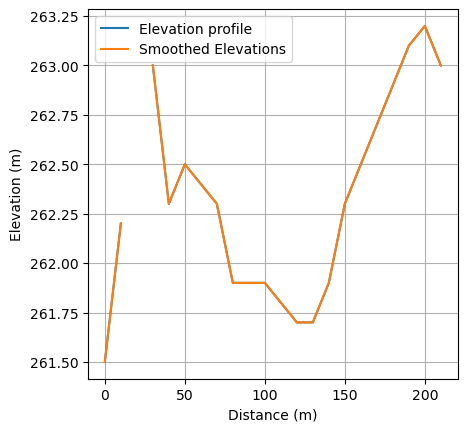

In [3]:
import random
random_key = random.choice([x for x in interpolated_points_dict.keys() if interpolated_points_dict[x].get('spline')])
test = interpolated_points_dict[random_key]

distance = test['distances']
elevation = test['elevations']
distance0 = np.array(list(range(0,distance[-1]+1,1)))
# smoothed_elevations = splev(distance,test['spline']) TODO this has a dimension mismatch
smoothed_elevations = np.interp(distance0, distance, elevation)

# Create the plot
fig, ax = plt.subplots()

# Plot the elevation profile
ax.plot(distance, elevation, label='Elevation profile')
ax.plot(distance0, smoothed_elevations, label='Smoothed Elevations')

# Set labels
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Elevation (m)')

# Ensure no vertical exaggeration by setting equal scale
# Here, the aspect ratio is based on the maximum range of the data
aspect_ratio = (max(distance) - min(distance)) / (max(elevation) - min(elevation))
ax.set_aspect(aspect_ratio)

# Add a grid and legend
ax.grid(True)
ax.legend()

# Show the plot
plt.show()
# elevation_tools.elevation_stats(distance,elevation,15)

Example

In [4]:
#TODO fix this part so i can compare the network line to the original line
# #select a link and try it
# linkid = 637636161
# link = links[links['osmid']==linkid].iloc[[0],:]

# #get osm line
# line = raw_links.loc[linkid,'geometry']#interpolated_points_dict[linkid]['geometry']
# line = np.array(line.coords)

# #get geo of start and end
# #or just use the included line to reduce memory?
# pointA = nodes[nodes['osm_N']==link['osm_A'].item()]
# pointB = nodes[nodes['osm_N']==link['osm_B'].item()]
# print(line)

In [5]:
# # Define the coordinates of two additional points
# point1 = (pointA.geometry.item().x,pointA.geometry.item().y)
# point2 = (pointB.geometry.item().x,pointB.geometry.item().y)
# print(point1,point2)

In [6]:
# # Plot the GeoDataFrame and the additional points
# fig, ax = plt.subplots()

# # plot the full link
# ax.plot(line[:,0],line[:,1], color='gray', label='full osm')

# link.plot(ax=ax, color='blue', label='osm segemnt')
# ax.plot(point1[0], point1[1], marker='o', color='red', markersize=10, label='Point 1')
# ax.plot(point2[0], point2[1], marker='o', color='green', markersize=10, label='Point 2')

# # Add labels to the additional points
# #ax.text(point1[0], point1[1], 'Point 1', fontsize=12, ha='right')
# #ax.text(point2[0], point2[1], 'Point 2', fontsize=12, ha='right')

# # Add legend and labels
# ax.legend()
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# ax.set_title('GeoDataFrame with Additional Points')

# # Manually set limits to create a square aspect ratio
# min_x, max_x = ax.get_xlim()
# min_y, max_y = ax.get_ylim()
# width = max(max_x - min_x, max_y - min_y)
# center_x = (min_x + max_x) / 2
# center_y = (min_y + max_y) / 2
# ax.set_xlim(center_x - width / 2, center_x + width / 2)
# ax.set_ylim(center_y - width / 2, center_y + width / 2)

# plt.show()


In [7]:
# point1_geo = Point(point1)
# point2_geo = Point(point2)
# line_geo = LineString(line)

Find the distance of the shapepoint on each line

In [8]:
# from shapely import line_locate_point, equals_exact

# point1_dist = line_locate_point(LineString(line),Point(point1))
# point2_dist = line_locate_point(LineString(line),Point(point2))

# #scenario 1: last point intersects with early point on a line (line loops into itself)
# #so trim off the points before point 1
# if point1_dist >= point2_dist:
#     for first_i, point in enumerate(line):
#         if equals_exact(Point(point),Point(point1),tolerance=1):
#             break
#     new_line = line[first_i+1:]
#     point2_dist = line_locate_point(LineString(new_line),Point(point1))

# #scenario 2: first point intersect with last point on a line
# #so trim off the point at the end of the line
# if point1_dist >= point2_dist:
#     new_line = line[0:-1]
#     point1_dist = line_locate_point(LineString(new_line),Point(point1))
#     point2_dist = line_locate_point(LineString(line),Point(point1))
    
# if point1_dist >= point2_dist:
#     print('error')
# else:
#     print(np.round(point1_dist),np.round(point2_dist))

# Interpolate distance on line
For each network link, use the pre-calculated start_dist and end_dist to interpolate elevation data from the fitted spline.

In [9]:
result = {}
test = []
for idx, row in tqdm(links.iterrows(),total=links.shape[0]):
    osmid = row['osmid']
    start_dist = row['start_dist']
    end_dist = row['end_dist']
    segment_length = row['geometry'].length # no need to convert to meters here

    if start_dist > end_dist:
        continue

    #get osm distances and elevation
    item = interpolated_points_dict.get(osmid,False)
    if isinstance(item,bool):
        print('no record for',idx)
        continue
    
    #get the max osm_dist
    osm_dist = item['distances'][-1]

    #retrieve the fitted spline if it exists
    spline = item.get('spline',0)

    if isinstance(spline,int):
        # in these cases a spline wasn't fit to the data because there were
        # only three data points so just assign it the same data as the osm way
        xs = item['distances']
        ys = item['elevations']
        if np.isnan(ys).any():
            continue
        result[row['linkid']] = {'distances':xs,'elevations':ys}
        continue

    # normal case
    if start_dist < end_dist:
        #if the end dist is past the osm dist, use the osm dist
        #this can happen if there's a rounding error
        if end_dist > osm_dist:
            end_dist = osm_dist
        
        # if the segment is less than 10 m, just use the first and last point for grade estimation
        if segment_length < 10:
            xs = [start_dist,end_dist]
            ys = splev(xs,spline)
        else:
            #get x values from start_dist to end_dist every 10 m
            xs = []
            while start_dist < end_dist:
                xs.append(start_dist)
                start_dist += 10
        
        xs = np.array(xs)
        # ys = splev(xs,spline)
        #NOTE I was getting a spline fit that was giving ludicrous numbers when interpolating
        #TODO fix the spline interpolation
        # until I can fix that, using piecewise linear interpolation
        ys = np.interp(xs, item['distances'], item['elevations'])
        #normalize xs so that it goes from 0 to end for the elevation stats function
        xs = xs - xs[0]
        result[row['linkid']] = {'distances':np.array(xs),'elevations':ys}

  0%|                                                                                                        | 0/38713 [00:00<?, ?it/s]

 12%|██████████▉                                                                               | 4688/38713 [00:00<00:00, 46877.70it/s]

 24%|█████████████████████▉                                                                    | 9446/38713 [00:00<00:00, 47287.19it/s]

 37%|████████████████████████████████▌                                                        | 14186/38713 [00:00<00:00, 47336.09it/s]

 49%|███████████████████████████████████████████▍                                             | 18920/38713 [00:00<00:00, 47196.08it/s]

 62%|██████████████████████████████████████████████████████▋                                  | 23814/38713 [00:00<00:00, 47823.16it/s]

 75%|██████████████████████████████████████████████████████████████████▍                      | 28874/38713 [00:00<00:00, 48763.59it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▌           | 33751/38713 [00:00<00:00, 44543.16it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████▋| 38552/38713 [00:00<00:00, 45577.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████| 38713/38713 [00:00<00:00, 46405.46it/s]

## Create link level elevation statistics
---
This is not at all an exhaustive method for aggregating elevation information. Feel free to experiment.

In [10]:
# export into QGIS to examine
export = {linkid:elevation_tools.simple_elevation_stats(item['distances'],item['elevations']) for linkid, item in result.items()}
export = pd.DataFrame.from_dict(export,orient='index')

df = pd.merge(links,export,left_on='linkid',right_index=True)
df['ascent_ft'] = (df['ascent_m'] * 3.28084).round(0)
df['descent_ft'] = (df['descent_m'] * 3.28084).round(0)
df['max_elev'] = np.max(np.abs(df[['ascent_ft','descent_ft']].values),axis=1)
df['max_grade'] = np.max(np.abs(df[['ascent_grade_%','descent_grade_%']].values),axis=1)
df['descent_ft'] = df['descent_ft'].abs()
df['descent_grade_%'] = df['descent_grade_%'].abs()
gdf = gpd.GeoDataFrame(df,crs=dem_crs)
gdf.to_crs(config['projected_crs_epsg'],inplace=True)
print(gdf['max_grade'].isna().sum(),'nan grades')
#remove nan grades, we'll fill them in the next one
gdf = gdf[gdf['max_grade'].notna()]

#fill in any nan values

# turn into 3 categories [< 4, 4-6, > 6]
bins = [0,4,6,np.inf]
labels = ['[0,4)','[4,6)','[6,inf)']
gdf['ascent_grade_cat'] = pd.cut(gdf['ascent_grade_%'],bins=bins,labels=labels,include_lowest=True).astype(str)
gdf['descent_grade_cat'] = pd.cut(gdf['descent_grade_%'],bins=bins,labels=labels,include_lowest=True).astype(str)
gdf['max_grade_cat'] = pd.cut(gdf['max_grade'],bins=bins,labels=labels,include_lowest=True).astype(str)

/Users/tannerpassmore/Documents/GitHub/BikewaySimDev/src/bikewaysim/network/elevation_tools.py:344: RuntimeWarning: invalid value encountered in scalar divide
  ascent_grade = np.round(ascent / total_distance * 100,2)
/Users/tannerpassmore/Documents/GitHub/BikewaySimDev/src/bikewaysim/network/elevation_tools.py:345: RuntimeWarning: invalid value encountered in scalar divide
  descent_grade = np.round(descent / total_distance * 100,2)


525 nan grades


In [11]:
x = gpd.read_file(config['network_fp']/'networks.gpkg',layer='osm_links',ignore_geometry=True)[['linkid','link_type']]
x = x.set_index('linkid')['link_type'].to_dict()
gdf['link_type'] = gdf['linkid'].map(x)

# Export

In [12]:
gdf.to_file(config['network_fp']/'elevation.gpkg')